## Compressed Sensing (Non-Uniform-Sampling) of MQMAS Experiment using Iterative Soft Thresholding

### Sodium poly

In [94]:

import pylab
import numpy
import scipy
from   scipy import fftpack
from   scipy.fftpack import fft, ifft, hilbert, fftshift, rfft 
import os
import nmrglue

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

%matplotlib inline

### IST Algorithm

In [95]:
def numPeaks( sss ):
    www = numpy.where( sss > 0 )
    numPeaks = 0
    ppp = www[0]
    for i in range(len(ppp[:-1])):
        v = www[0][i]
        v1 = www[0][i+1]
        if v1-v > 1:
            numPeaks +=1

    return( numPeaks ) 



def compressed_sensing_1VD( fid, mask, num_iter=500, factor=0.95, tol = 0.01, maxPeaks=2 ):
    
    sss = numpy.zeros( len(fid))
    sss0 = numpy.zeros( len(fid))
    
    final_iter_value  = 0
    final_tol_value   = 0
    final_numpeaks_value = 0

    fid1 = fid.copy()
    tol_diff = (numpy.sqrt(((abs(fid1)).sum())/32.))
    
    k=0
    rrr = fftpack.fft(fid1)
    rss0 = []
    rss0.append(abs(rrr).sum())
    
    tol0 = abs(rrr).sum()
    tol_diff = ( tol0 - abs(rrr).sum() )*100.0 / tol0
    while (tol_diff < tol) and (k < num_iter) and numPeaks( sss ) <maxPeaks:
        
        sss0 = 1.0*sss
        
        rrr = fftpack.fft(fid1)
        m1 = max(rrr.real)
        
        sss_max_old = sss.max()
               
        for i,r in enumerate(rrr):
            if r.real > m1* factor:
                sss[i] = sss[i]+rrr[i].real-m1*factor
                rrr[i] = complex(m1*factor)
        sss_max = sss.max()
        
        rrr_iii = fftpack.hilbert( rrr.real )
        
        rrr = rrr.real + 1j * rrr_iii
        
        fid1 = fftpack.ifft(rrr)
        
        fid1 *= mask
        tol_diff = ( tol0 - abs(rrr).sum() )*100.0 / tol0
        k +=1

    final_iter_value = k
    final_numpeaks_value = numPeaks(sss)
    final_tol_value = tol_diff
    
    return( sss0, [final_iter_value, final_numpeaks_value, final_tol_value ] )

In [96]:
def numPeaks( sss ):
    www = numpy.where( sss > 0 )
    numPeaks = 0
    ppp = www[0]
    for i in range(len(ppp[:-1])):
        v = ppp[i]
        v1 = ppp[i+1]
        if v1-v > 1:
            numPeaks +=1

    return( numPeaks ) 



def compressed_sensing_1D_VI( fid, mask, num_iter=500, factor=0.95, tol = 0.01, maxPeaks=2 ):
    
#    print tol
    sss = numpy.zeros( len(fid))
    
    final_iter_value  = 0
    final_tol_value   = 0
    final_numpeaks_value = 0
    
    tolerance = []
    numberOfpeaks = []
    
    fid1 = fid.copy()
    tol_diff = 1000.0
    
    k=0
    rrr = fft(fid1)
    
#    print "tol_diff",tol_diff
#    print "Num Peaks", numPeaks( sss )
    
    
    while (tol_diff > tol) and (k < num_iter) and numPeaks( sss ) < maxPeaks:
        
        rrr = fft(fid1)
        m1 = max(rrr.real)*factor
               
        for i,r in enumerate(rrr):
            if r.real > m1:
                sss[i] = sss[i]+rrr[i].real-m1
                rrr[i] = complex(m1)
        rrr = rrr.real + 1j * hilbert( rrr.real )
        
        fid1 = ifft(rrr)*mask

        fid00 = ifft(sss+1j*hilbert(sss))*mask
        
        tol_diff = (abs(fid00.real-fid.real)).sum()
        tolerance.append(tol_diff)
        numberOfpeaks.append( numPeaks( sss ))
        k +=1
#        print tol_diff,k,
        

        
    final_iter_value = k
    final_numpeaks_value = numPeaks(sss)
    final_tol_value = tol_diff
    
    return( sss, [final_iter_value, numberOfpeaks, tolerance ] )




### Matplotlib Class to plot 2D NMR spectrum

In [97]:
class TwoD_NMR_MAT_plot:
    
    def __init__(self, exp, pinfo, info, dimensions_ppm=[]):
        
        print exp.shape
        
        self.exp = exp
        self.pinfo = pinfo
        self.info  = info
        
        self.rr,self.cc = exp.shape
        self.X = np.zeros(exp.shape)
        self.Y = np.zeros(exp.shape)
        
        r1=0
        r2=self.rr

        c1=0
        c2=self.cc
        
        print r2,c2
        
        self.create_axes(  pinfo, info, self.rr, self.cc, dimensions_ppm )
          
        self.create_plot_layout(self.dimensions_index)
        
        self.plot_plots()
        

        
    def create_axes( self, pinfo, info, rr,cc, dimensions_ppm):
                
        self.f1_offset_p = pinfo['procs' ]['OFFSET']
        self.f1_sw_hz     = pinfo['procs' ]['SW_p']
        self.f1_omega    = pinfo['procs' ]['SF']
        self.f1_sw_ppm   = self.f1_sw_hz/self.f1_omega
        
        self.f2_offset_p = pinfo['proc2s' ]['OFFSET']
        self.f2_sw_hz     = pinfo['proc2s' ]['SW_p']
        self.f2_omega    = pinfo['proc2s' ]['SF']
        self.f2_sw_ppm   = self.f2_sw_hz/self.f2_omega
        print self.f1_sw_ppm
        
        self.f1 = np.linspace(self.f1_offset_p, self.f1_offset_p-self.f1_sw_ppm,  self.rr)
        self.f2 = np.linspace(self.f2_offset_p, self.f2_offset_p-self.f2_sw_ppm,  self.cc)
        
        self.dw_f1_ppm = self.f1[1]-self.f1[0]
        self.dw_f2_ppm = self.f2[1]-self.f2[0]
        
        for r in range(self.rr):
    
            for c in range( self.cc):
        
                self.Y[r,c] = self.f1[r]
                self.X[r,c] = self.f2[c] 
                
        print dimensions_ppm       
        if dimensions_ppm == []:
            self.dimensions_index = scipy.array([0,self.rr-1,0,self.cc-1])
        else:
            r1 = int( (dimensions_ppm[1]-self.f1_offset_p)/self.dw_f1_ppm)
            r2 = int( (dimensions_ppm[0]-self.f1_offset_p)/self.dw_f1_ppm)
            c1 = int( (dimensions_ppm[2]-self.f2_offset_p)/self.dw_f2_ppm)
            c2 = int( (dimensions_ppm[3]-self.f2_offset_p)/self.dw_f2_ppm)
            
            self.dimensions_index = scipy.array([r1,r2,c1,c2 ])
            
        print "self.dimensions_index", self.dimensions_index
            
        self.Z1 = self.exp[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        self.X1 =   self.X[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        self.Y1 =   self.Y[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        
        
    def create_plot_layout( self, dimensions_index):
        
        print "dimensions_index",dimensions_index
        
        nullfmt   = NullFormatter()         # no labels

        # definitions for the axes
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        bottom_h = left_h = left+width+0.02

        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.2]
        rect_histy = [left_h, bottom, 0.2, height]

        # start with a rectangular Figure
        plt.figure(2, figsize=(6,6))

        self.axScatter = plt.axes(rect_scatter)
        self.axHistx = plt.axes(rect_histx)
        self.axHisty = plt.axes(rect_histy)

# no labels
        self.axHistx.xaxis.set_major_formatter(nullfmt)
        self.axHisty.yaxis.set_major_formatter(nullfmt)
        
        self.axScatter.tick_params(axis='x', labelsize=16)
        self.axScatter.tick_params(axis='y', labelsize=16)
        self.axScatter.set_xlabel('${^1}$H [ppm]',fontsize=16)
        #ax.set_xlim(-60, 60)
        self.axScatter.set_ylabel('${^1}$H [ppm]', fontsize=16)
        
        self.axHistx.axis('off')
        self.axHisty.axis('off')

        f1_start = self.f1[dimensions_index[0]]
        f1_end   = self.f1[dimensions_index[1]]

        f2_start = self.f2[dimensions_index[2]]
        f2_end   = self.f2[dimensions_index[3]]

        self.axScatter.set_ylim( (f1_start, f1_end) )
        self.axScatter.set_xlim( (f2_start, f2_end) )
        
        

    def plot_plots(self):
        
        # the scatter plot:
        cl = np.linspace(self.Z1.max()*0.01, self.Z1.max()*1.1,10)
        print "Z1.shape",self.Z1.shape
        

        sum_f1 = self.Z1.sum(axis=0)
        print "len(sum_f1)",len(sum_f1)
        sum_f2 = self.Z1.sum(axis=1)
        print "len(sum_f2)",len(sum_f2)

        cset = self.axScatter.contour(self.X1, self.Y1, self.Z1,  cl,  colors='red')
        #
        self.axHistx.plot(sum_f1, 'r-')
        self.axHisty.plot(sum_f2,range(len(sum_f2)),'r')


        self.axHistx.set_xlim( (0,len(sum_f1)-1) )
        self.axHisty.set_ylim( (0,len(sum_f2)-1) )        
        
        
        

### Read in Experimental Data

In [98]:


f1=64
zerofill = 512
f2=1024
pp=32


expt_no = "16"  # PGSTE -MAT, 32 scans, D1=1s, 15Hz, 32_64 from 200

directory = os.path.join("Y:", os.sep,"SSNMR","Backup", "Avance", "bdat07","eeh_20160115_mqmas" )

expt_no = "10"  # PGSTE -MAT, 32 scans, D1=1s, 15Hz, 32_64 from 200

directory = os.path.join("Y:", os.sep,"SSNMR","Backup", "Avance", "bdat07","eeh_20160124_mqmas" )
#directory = os.path.join( "NMRDATA","eeh_20150710_4mmHXG_MAT" )


expt_no = "2"  # PGSTE -MAT, 32 scans, D1=2.5s, 102Hz, 32_64 from 64, , BD=100ms, grad = 80%
directory = os.path.join("Y:", os.sep,"SSNMR","Backup", "Avance", "bdat07","eeh_20160129_1_4mmHXG_50umBeads" )

file_rrr = os.path.join( directory, expt_no, "pdata", "1")

file_ser = os.path.join(directory,expt_no)
                         
cs_file  = os.path.join( directory,expt_no,"nuslist")
cs_file  = os.path.join( directory,expt_no,"vdlist")
file1    = os.path.join( directory,expt_no,"pdata","1","2rr" )



max_num_peaks = 100
tolerance = 80e3
iterations = 500

In [99]:
pinfo,expt = nmrglue.fileio.bruker.read_pdata( file_rrr )
print expt.shape
info,expt_fid = nmrglue.bruker.read( file_ser )
print expt_fid.shape

(512L, 1024L)
(64L, 512L)


119544


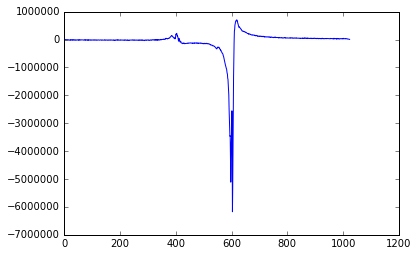

In [100]:
pylab.plot(expt[-1].real);
nus_pts=32
print  ((abs(expt[0][-nus_pts:].real)).sum())

In [101]:
## transfer fid into matrix with dimensions of final FFT spectra

## transfer fid into matrix with dimensions of final FFT spectra

(rr,cc) = expt.shape
expt = numpy.zeros((rr,cc),dtype=numpy.complex128)

(rr,cc) = expt_fid.shape
for r in range(rr):
    for c in range(cc):
        expt[r][c] = expt_fid[r][c]
        
del expt_fid

In [102]:
## read in compressed sensing positions 

cs_array = scipy.fromfile( cs_file, sep = " " )
cs_array = scipy.array( cs_array, dtype=numpy.int32 )

numpts = zerofill
mask = numpy.zeros(numpts, dtype=numpy.float32)

for i in cs_array[:pp]:
    mask[i] = 1.0


898360.64679


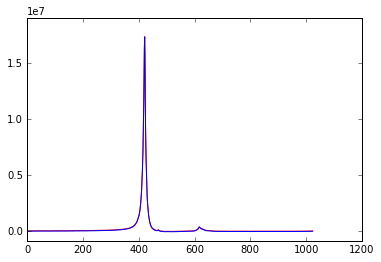

In [103]:
# Fourier Transform in F2 dimension

spec = fftpack.fft(expt, axis=1)
spec = fftpack.fftshift(spec, axes=1)


# Phase correct data and remove Bruker digitization artefacts

spec = nmrglue.process.proc_base.ps(spec, p0=-pinfo['procs']['PHC0']+0.0, p1=info['acqus']['GRPDLY']*360.0-pinfo['procs']['PHC1'], inv=False)


#Apply a simple base line correction to spectra in F2 dimension

(f1a,f2a) = expt.shape
pylab.plot(spec[0].real, 'r-');

for i in range(f1a):
    spec[i] = spec[i] - (spec[i][:100]).mean()
    
for i in range(f1a):
    spec[i] = spec[i] - (spec[i][:100]).mean()
    

pylab.plot(spec[0].real, 'b');
pylab.ylim(-0.05*spec[0].max(), 1.1*spec[0].max());
print  ((abs(spec[0][-nus_pts:].real)).sum())

In [104]:
#  Split real and imaginary

iii_cs = spec[1::2].real
rrr_cs = spec[::2].real

In [105]:
# Create real and imag data arrays and put fids in correct position and order

rrr =scipy.zeros((zerofill,f2), dtype=numpy.int32)
iii =scipy.zeros((zerofill,f2), dtype=numpy.int32)


for i,v in enumerate(cs_array):
    rrr[v] = rrr[v]+rrr_cs[i]
    iii[v] = iii[v]+iii_cs[i]

In [106]:
# find the maximum index value in the first spectrum. Value used in he thresh-holding algorihm

mp =rrr[0].argmax()
rrr = rrr.transpose()
iii = iii.transpose()

print mp

mmm_t = (rrr + 1j*iii)

421


### Perform Iterative Soft Thesholding Procedure in T$_1$ dimension

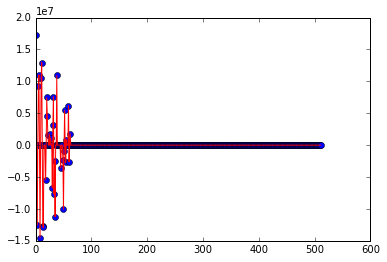

In [107]:
pylab.plot( mask*mmm_t[mp].real, 'o' );
pylab.plot( mmm_t[mp].real, 'r-' );

In [108]:

fid =  mmm_t[mp].copy()
fid0 =  mmm_t[-1].copy()
output = compressed_sensing_1D_VI( fid, mask, num_iter=500, factor=0.95, tol =0.1, maxPeaks=100)

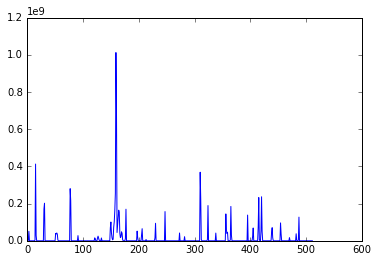

In [109]:

pylab.plot(fftshift(output[0])+40);


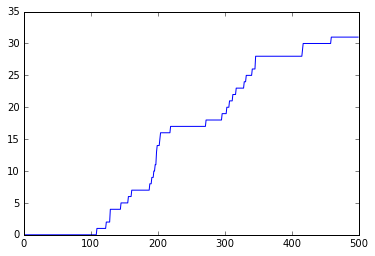

In [110]:
npeaks = scipy.array(output[1][1])
pylab.plot(npeaks);

(array([108, 122, 128, 144, 155, 160, 187, 190, 193, 195, 197, 198, 202,
       203, 218, 271, 295, 302, 306, 311, 316, 328, 331, 340, 345, 415,
       416, 458], dtype=int64),)
<type 'numpy.ndarray'>
[14  6 16 11  5 27  3  3  2  2  1  4  1 15 53 24  7  4  5  5 12  3  9  5 70
  1 42]
2 122


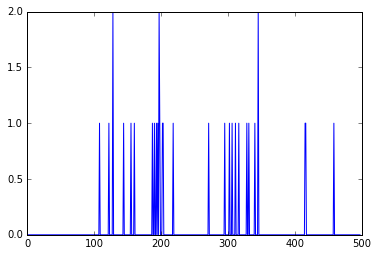

In [111]:
#print help(scipy.argsort)
sss=fftshift(output[0]).real
ddd = abs(npeaks[:]-numpy.roll(npeaks,-1))
#ddd = abs(sss[:]-numpy.roll(sss,-1))

ddd1 = ddd[:]-numpy.roll(ddd,-1)
pylab.plot((ddd[:-2]));
#pylab.plot((ddd1[:-2]));
print numpy.where(ddd[:-2])
ppp = (numpy.where(ddd[:-2]>0))[0]
print type(ppp)
print ppp[1:]-ppp[:-1]
ppp1 = ppp[1:]-ppp[:-1]


i=0
while ppp1[i] > 10:
    i += 1
    
print i+1, ppp[i]


output = compressed_sensing_1D_VI( fid, mask, num_iter=ppp[i], factor=0.95, tol =0.1, maxPeaks=i+1)

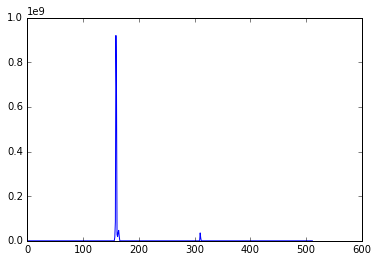

In [112]:
pylab.plot(fftshift(output[0])+40);


In [113]:
# Perform thresholding in T1 for each point

cs_spec = scipy.zeros((f2,zerofill), dtype=numpy.complex128)

stats_array = []

for j in range(f2):
    print j,

#    Y, stats = compressed_sensing_1VD( mmm_t[j], mask, num_iter=iterations, tol=1, maxPeaks=3  )    
    output = compressed_sensing_1D_VI( mmm_t[j], mask, num_iter=500, factor=0.95, tol =0.1, maxPeaks=20)
    npeaks = scipy.array(output[1][1])
#    cs_spec[j] = (Y + 1j * fftpack.hilbert( Y ))
    
    sss=fftshift(output[0]).real
    ddd = abs(npeaks[:]-numpy.roll(npeaks,-1))

    ddd1 = ddd[:]-numpy.roll(ddd,-1)
#pylab.plot((ddd[:-2]));
#pylab.plot((ddd1[:-2]));
#print numpy.where(ddd[:-2])
    ppp = (numpy.where(ddd[:-2]>0))[0]
#print type(ppp)
#print ppp[1:]-ppp[:-1]
    ppp1 = ppp[1:]-ppp[:-1]


    i=3
    while ppp1[i] > 10:
        i += 1
    
#rint i+1, ppp[i]


    Y, stats = compressed_sensing_1D_VI( mmm_t[j], mask, num_iter=ppp[i], factor=0.95, tol =0.1, maxPeaks=i+1)
    cs_spec[j] = (Y + 1j * fftpack.hilbert( Y ))


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

### Display Results

In [114]:
for m in range(f2):
    cs_spec[m] = fftpack.fftshift(cs_spec[m])

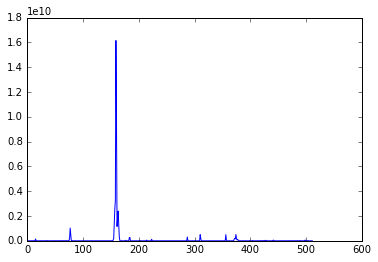

In [115]:
# Display high resolution projection 

cs_spec_sum1 = (cs_spec.real).sum(axis=1) 
#print cs_spec_sum1.max(), (cs_spec_sum[:]).sum()
ssum0 = (cs_spec.real).sum(axis=0)

pylab.plot( (cs_spec.real).sum(axis=0) );


In [116]:
spec = fftpack.fft(mmm_t, axis=1)

In [117]:
cs_spec_real = (cs_spec.real/10000.0)

In [118]:
cs_spec_int32 = scipy.array(cs_spec_real, dtype=scipy.int32)

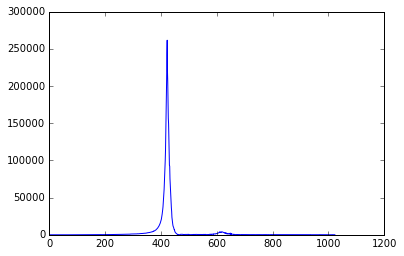

In [119]:
pylab.plot(((cs_spec_int32).sum(axis=1)));

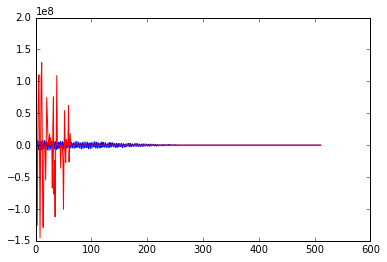

In [120]:
pylab.plot( fftpack.ifft(cs_spec[mp]).real );
pylab.plot( 10*mmm_t[mp].real, 'r-' );

In [121]:
# Arrange 2-D spectrum  in correct order for display with Bruker Topsin

cs_spec_int32 = cs_spec_int32.transpose()
cs_spec_int32 = numpy.fliplr(cs_spec_int32)
cs_spec_int32 = numpy.flipud(cs_spec_int32)

In [122]:
cs_spec_int32 = cs_spec_int32.flatten()

In [123]:
#Store 2-D real spectum in Bruker daa directory

fp = open( file1, 'wb' )
cs_spec_int32.tofile(fp)
fp.close()

In [124]:
stats_array = numpy.array(stats_array)

In [125]:
stats_array = stats_array.transpose()

In [126]:
#final iteration value
#pylab.plot( stats_array[0] ); 

In [127]:
# final peaks found
#pylab.plot( stats_array[1] ); 

In [128]:
# final tolerance
#pylab.plot( stats_array[2] ); 

In [129]:
#file_rrr = r'Z:\Documents\work\projects\CompressedSensing\Data\eeh_20140228_diffMAT_4mmHXG\224\pdata\1'
#info,expt = nmrglue.bruker.read_pdata( file_rrr )

expt = cs_spec_real

expt = np.flipud(expt)
expt = np.fliplr(expt)
expt = expt.transpose()

(512L, 1024L)
512 1024
24.9893824011
[]
self.dimensions_index [   0  511    0 1023]
dimensions_index [   0  511    0 1023]
Z1.shape (511L, 1023L)
len(sum_f1) 1023
len(sum_f2) 511


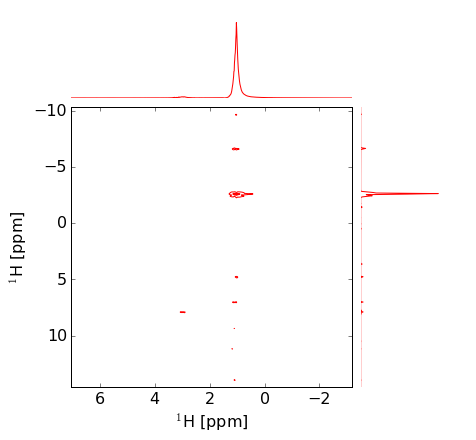

In [130]:
ppplot = TwoD_NMR_MAT_plot( expt, pinfo, info)

(512L, 1024L)
512 1024
24.9893824011
[-1, 8, 7, -1]
self.dimensions_index [135 319   4 804]
dimensions_index [135 319   4 804]
Z1.shape (184L, 800L)
len(sum_f1) 800
len(sum_f2) 184


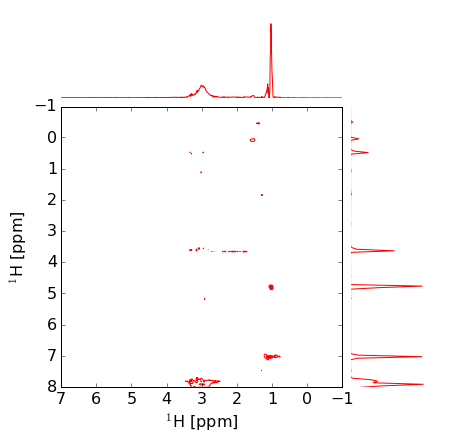

In [131]:
ppplot = TwoD_NMR_MAT_plot( expt, pinfo, info, [-1,8,7,-1])

In [132]:
print scipy.__version__
print nmrglue.__version__
print matplotlib.__version__
print numpy.__version__

0.16.0
0.5-dev
1.5.1
1.10.1


(512L, 1024L)
512 1024
24.9893824011
[5, 7, 7, -1]
self.dimensions_index [155 196   4 804]
dimensions_index [155 196   4 804]
Z1.shape (41L, 800L)
len(sum_f1) 800
len(sum_f2) 41


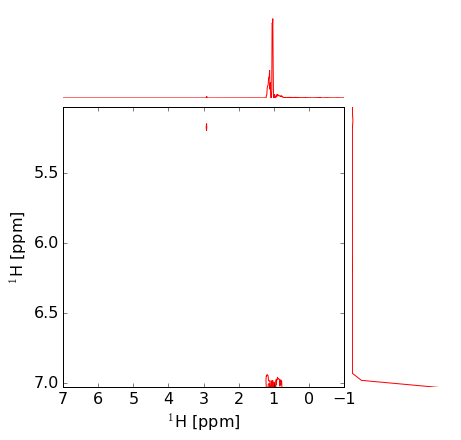

In [133]:
ppplot = TwoD_NMR_MAT_plot( expt, pinfo, info, [5,7,7,-1])